# Wordcloud from website

In this notebook I directly create a wordcloud from the [Wikipedia entry for data science](https://en.wikipedia.org/wiki/Data_science) without the intermediate PDF file. The implementation relies on work from my colleague [Juan Fernando Varela](https://github.com/JFVJ/Lemmatization-in-Spanish-Wordcloud-), the blog entry [Word Cloud in 3 Basic Steps with Python](https://gustavorsantos.medium.com/word-cloud-in-3-basic-steps-with-pythonb-c5a97537b9d6) and the web scraping I implement to extract the relevant text.

The web scraping relies on the library `BeautifulSoup`, which transforms an HTML document into a navigable tree structure to make it amenable to programming and automated parsing. This library sits on top of HTML to allow to search the HTML document, make edits to the document and extract information from it (DeGeest, 2022). 

In [1]:
from bs4 import BeautifulSoup
import urllib
import requests
import re
import string
import nltk
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jacasta2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Scrap and clean data

I scrap the [Wikipedia entry for data science](https://en.wikipedia.org/wiki/Data_science).

In [2]:
### Read the website and load it into a BeautifulSoup object

site_url = "https://en.wikipedia.org/wiki/Data_science"
site_content = requests.get(site_url).text
s = BeautifulSoup(site_content, "html.parser")

We could save the website in a .html file for further processing.

    with open("Wikipedia_DataScience.html", "w") as f:
        f.write(site_content)

In [3]:
### We can take a look at the object

# We only show a portion of the text
print(s.prettify()[:500])

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-language-alert-in-sidebar-enabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-enabled vector-feature-main-menu-pinned-disabled vector-feature-limited-width-enabled vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled" dir="ltr" lang="en">
 <head>
  <meta cha


In [4]:
### We can check how long the object is

len(s.prettify())

183130

In [5]:
### We can print it all and check whether we can start noting where the relevant text is

# A quick look suggests the relevant text is inside 'p' tags
print(s.prettify())

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-language-alert-in-sidebar-enabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-enabled vector-feature-main-menu-pinned-disabled vector-feature-limited-width-enabled vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Data science - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-language-alert-in-sidebar-enabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-enabled vector-feature-main-menu-pinned-disabled vector-feature-limited-width-enabled vector-feature-limited-width-content-ena

In [6]:
### Let's check all 'p' tags with the method find_all()

s.find_all("p")

[<p class="mw-empty-elt">
 </p>,
 <p><b>Data science</b> is an <a class="mw-redirect" href="/wiki/Interdisciplinary" title="Interdisciplinary">interdisciplinary</a> academic field <sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup> that uses <a href="/wiki/Statistics" title="Statistics">statistics</a>, <a class="mw-redirect" href="/wiki/Scientific_computing" title="Scientific computing">scientific computing</a>, <a href="/wiki/Scientific_method" title="Scientific method">scientific methods</a>, processes, <a href="/wiki/Algorithm" title="Algorithm">algorithms</a> and systems to extract or extrapolate <a href="/wiki/Knowledge" title="Knowledge">knowledge</a> and insights from noisy, structured, and <a href="/wiki/Unstructured_data" title="Unstructured data">unstructured data</a>.<sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>
 </p>,
 <p>Data science also integrates domain knowledge from the underlying application domain (e.g., natural 

In [7]:
### We can print them all

for p in s.find_all("p"):
    print(p)

<p class="mw-empty-elt">
</p>
<p><b>Data science</b> is an <a class="mw-redirect" href="/wiki/Interdisciplinary" title="Interdisciplinary">interdisciplinary</a> academic field <sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup> that uses <a href="/wiki/Statistics" title="Statistics">statistics</a>, <a class="mw-redirect" href="/wiki/Scientific_computing" title="Scientific computing">scientific computing</a>, <a href="/wiki/Scientific_method" title="Scientific method">scientific methods</a>, processes, <a href="/wiki/Algorithm" title="Algorithm">algorithms</a> and systems to extract or extrapolate <a href="/wiki/Knowledge" title="Knowledge">knowledge</a> and insights from noisy, structured, and <a href="/wiki/Unstructured_data" title="Unstructured data">unstructured data</a>.<sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>
</p>
<p>Data science also integrates domain knowledge from the underlying application domain (e.g., natural science

In [8]:
### We can print just the text inside the 'p' tags. Look how useful the method get_text() is: it takes care of
### extracting the text from the nested 'a' tags

# I also store all the text in a string for further processing
text = ""
for p in s.find_all("p"):
    print(p.get_text())
    text = text + p.get_text()



Data science is an interdisciplinary academic field [1] that uses statistics, scientific computing, scientific methods, processes, algorithms and systems to extract or extrapolate knowledge and insights from noisy, structured, and unstructured data.[2]

Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).[3] Data science is multifaceted and can be described as a science, a research paradigm, a research method, a discipline, a workflow, and a profession.[4]

Data science is a "concept to unify statistics, data analysis, informatics, and their related methods" to "understand and analyze actual phenomena" with data.[5] It uses techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, information science, and domain knowledge.[6] However, data science is different from computer science and information science. Turing Award winner Jim Gray i

A look at the text reveals the citations are still part of it. The citations are inside square brackets. We'll use the method `sub()` from the `Regular Expression` library to delete the square brackets and the content inside them. After implementing the method, we'll replace the double blank spaces left by the citation removal with single blank spaces.

This work relies on the question [Remove text between () and []](https://stackoverflow.com/questions/14596884/remove-text-between-and) from **Stack Overflow** and the entry [How to remove brackets from text file in Python?](https://www.geeksforgeeks.org/how-to-remove-brackets-from-text-file-in-python/) from **GeeksforGeeks**.

In [9]:
text = ""
for p in s.find_all("p"):
    line = p.get_text()
    line = re.sub("[\(\[].*?[\)\]]", "", line).replace("  ", " ")
    text += line
    print(line)



Data science is an interdisciplinary academic field that uses statistics, scientific computing, scientific methods, processes, algorithms and systems to extract or extrapolate knowledge and insights from noisy, structured, and unstructured data.

Data science also integrates domain knowledge from the underlying application domain . Data science is multifaceted and can be described as a science, a research paradigm, a research method, a discipline, a workflow, and a profession.

Data science is a "concept to unify statistics, data analysis, informatics, and their related methods" to "understand and analyze actual phenomena" with data. It uses techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, information science, and domain knowledge. However, data science is different from computer science and information science. Turing Award winner Jim Gray imagined data science as a "fourth paradigm" of science and asserted that "everyth

From now on we only need to replicate the implementation in the notebook `wordcloud_from_pdf.ipynb` after loading the PDF file

In [10]:
### Transform all the words to lowercase

text = text.lower()

In [11]:
# Remove punctuation
    # https://www.w3schools.com/python/ref_string_maketrans.asp

mytable = str.maketrans("", "", string.punctuation)
text = text.translate(mytable)

## 2. Prepare data

We use the `nlkt` tokenizer to transform each word in a single token. We then remove the stopwords (words that don’t carry any real meaning such as the, and, or, it, etc.).

In [12]:
### Load stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))

### Tokenize text
tokens = word_tokenize(text)

### Remove stopwords
text_clean = [word for word in tokens if word not in stopwords]

## 3. Generate the wordcloud

We re-join the now clean list of tokens into a single text and generate the cloud.

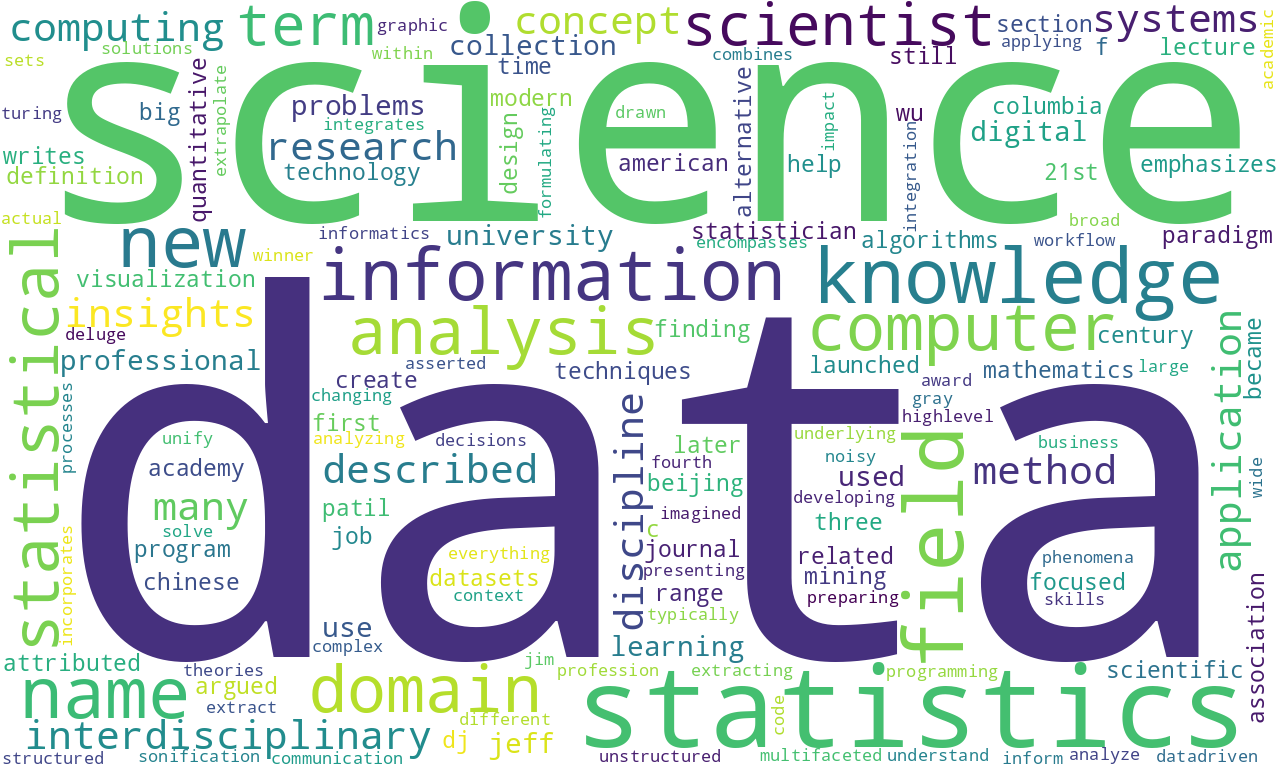

In [13]:
### Generate the text
text = ' '.join(text_clean)

### Create a WordCloud object
wordcloud = WordCloud(background_color = "white", max_words = 150, contour_width = 3, contour_color = "steelblue", \
    width = 1280, height = 769, scale = 1, max_font_size = 500, collocations = False)

### Generate a wordcloud
wordcloud.generate(text)

### Save the wordcloud
#wordcloud.to_image().save("datascience_wordcloud.png")

### Visualize the wordcloud
wordcloud.to_image()

## References

DeGeest, S. (2022). *Automating the extraction of financial data for stocks* [Jupyter notebook]. Correlation One, Data Science For All.